# BREAST CANCER CLASSIFICATION USING RANDOM FOREST


# PROBLEM STATEMENT


- Predicting if the cancer diagnosis is benign or malignant based on several observations/features
- 30 features are used, examples:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

- Datasets are linearly separable using all 30 input features
- Number of Instances: 569
- Class Distribution: 212 Malignant, 357 Benign
- Target class:
         - Malignant
         - Benign




DATA SOURCE: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)

# CODE TO SOLVE THE PROBLEM:

## STEP 0: IMPORTING THE LIBARARIES:

In [1]:
pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 2.0 MB/s eta 0:00:00


In [2]:
# import libraries
import pandas as pd # Importing Pandas for data manipulation using dataframes
import numpy as np # Importing Numpy for data statistical analysis
import matplotlib.pyplot as plt # Import matplotlib for data visualisation
import seaborn as sns # Statistical data visualization

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix, roc_auc_score, roc_curve, auc

from skopt import BayesSearchCV

from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

## STEP 1: LOADING THE DATA

In [3]:
# Import Cancer data drom the Sklearn library
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

In [4]:
print(cancer['target_names'])

['malignant' 'benign']


In [5]:
print(cancer['feature_names'])

['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


In [6]:
cancer['data'].shape

(569, 30)

In [7]:
df_cancer = pd.DataFrame(np.c_[cancer['data'], cancer['target']], columns = np.append(cancer['feature_names'], ['target']))

## STEP 2: VISUALIZE THE DATA

### 2.1 Representing the target variable:

<Axes: xlabel='target', ylabel='count'>

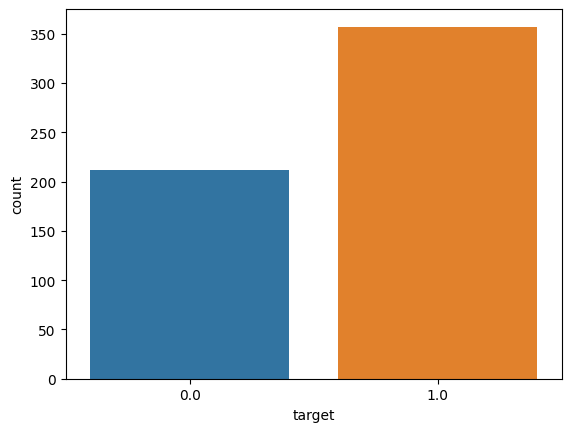

In [8]:
sns.countplot(x=df_cancer['target'], label = "Count")

From this representation we can see that we have an unbalanced dataset. Therefore we will have to tackle it later when splitting teh training and testing test in the part 4.2.

### 2.2 Data Distribution and relation to Target:    
I will look into the boxplots of each features, this way I can see how the feature values are distributed with respect to each class. This can be helpful to identify if any features have different median values for different classes, which is useful for classification.

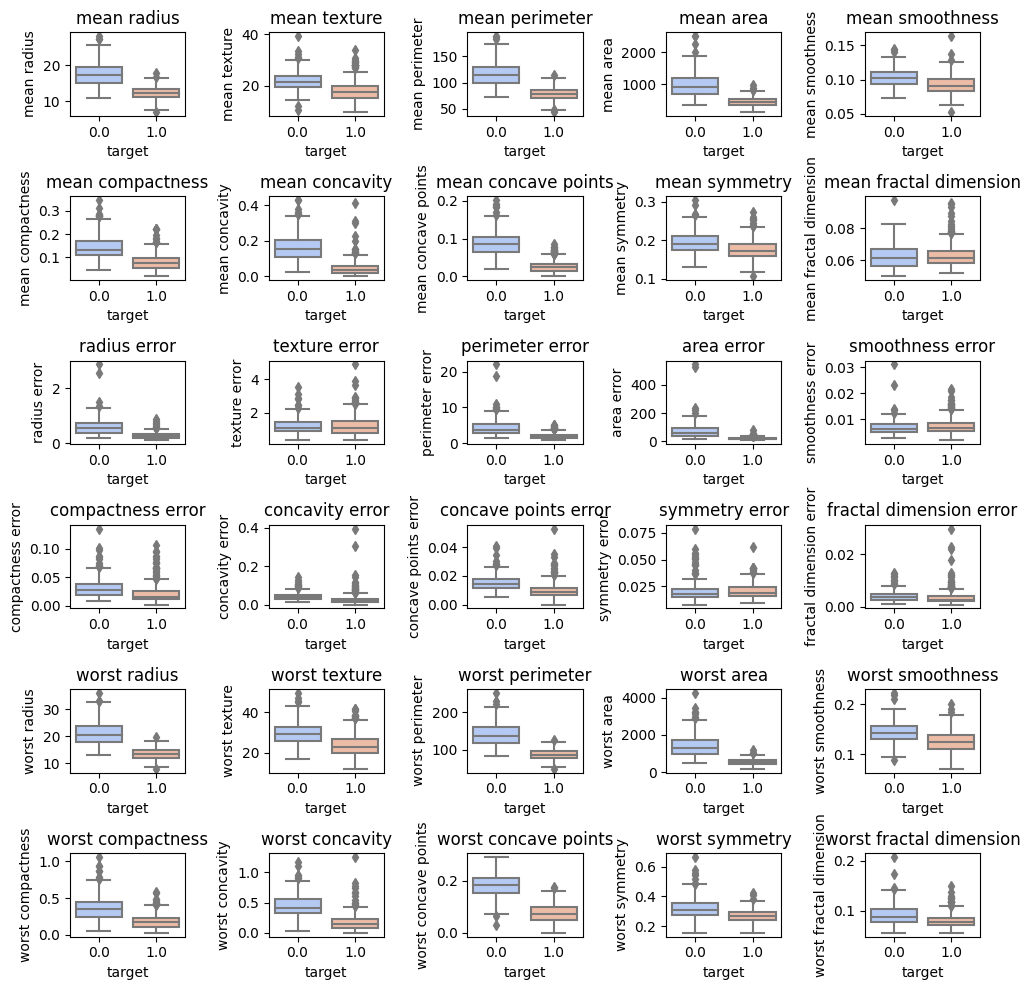

In [9]:
# Plot boxplots for each feature
plt.figure(figsize=(10, 10))

# We plot a boxplot for each feature
for i, feature in enumerate(cancer['feature_names']):
    plt.subplot(6, 5, i + 1)  # We have 30 features, so 6 rows and 5 cols are chosen
    sns.boxplot(x='target', y=feature, data=df_cancer, palette="coolwarm")
    plt.title(feature)
    plt.tight_layout()

plt.show()

From this representation we can get different insights:
- *worst concave*, *worst area*, *worst* perimeter, *worst radius*, *mean radius* and *mean perimeter* points seems to be a good fetaure to differentiate malignant and benign breasts.  
-*mean fractal dimension*, *smoothness error*, *symmetry error*, *texture error* and *mean fractal dimension error* on the other hand seem to be useful to differentiate malignant and benign breasts.

Also it is pretty east to observe the variables with a lot of outliers like the *mean fractal dimension*, *fractal dimension error*, *worst concavity* and *compactness error* for instance.

### 2.3 Correlation Matrix:

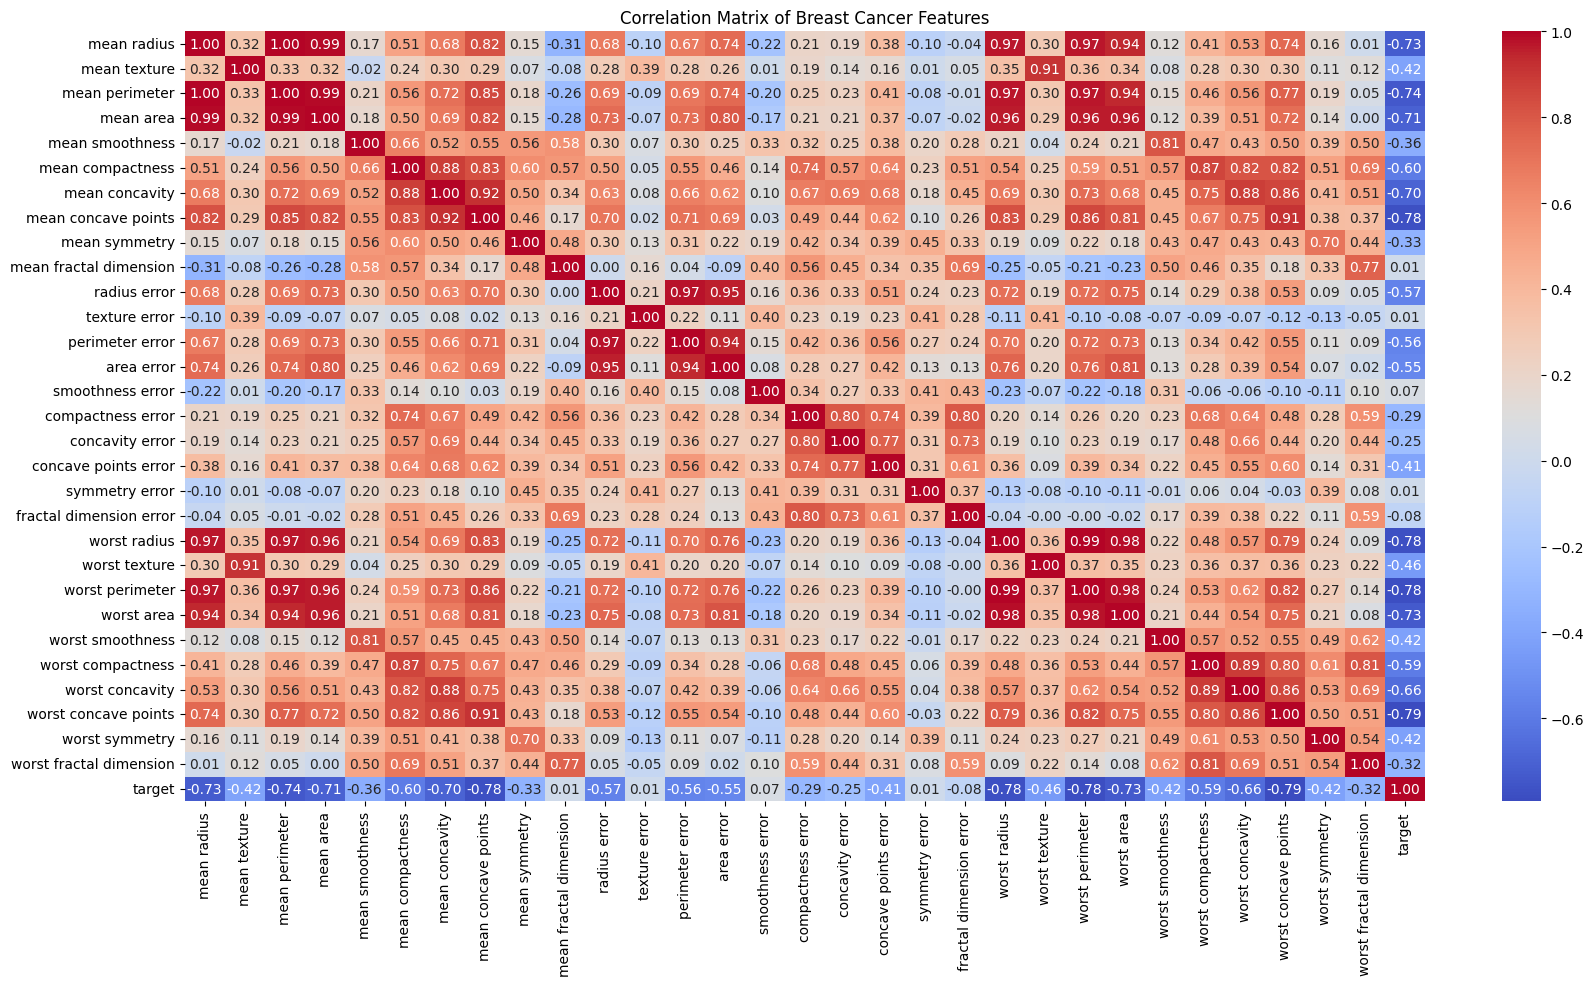

In [10]:
# Set up the matplotlib figure
plt.figure(figsize=(20, 10))

# Draw the heatmap
sns.heatmap(df_cancer.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Breast Cancer Features')
plt.show()

From the correlation matrix we can see that some features have a very low correlation with the target variable and therefore should not be taken into considertion:
- mean fractal dimension
- texture error
- symmetry error
- smoothness error
- fractal dimension error

Based on the correlation matrix, we observe taht some features are also highly correlated (1 or 0.99) between them, probably because they convey the same information. In order to avoid multicolinearity it is important to drop some of them.   
For instance *mean radius*, *mean perimeter*, and *mean area* are highly correlated because they all describe the size of the tumor. From some personal research, it seems that *mean area* might be the most comprehensive one since it captures the actual size, whereas 'mean radius' and 'mean perimeter' are more abstract and derived from the area in a circular assumption context. Therefore, I will drope *mean radius* and *mean perimeter*.


Similarly, *radius error*, *perimeter error*, and *area error* are highly correlated (1, 0.95 and 0.94). In this case, from my understanding *area error* seem to be the most comprehensive fetaure. Therefore I will drop *radius error*, *perimeter error*.

Similarly, *worst radius*, *worst perimeter*, and *worst area* are highly correlated too (1, 0.98, 0.99). To go hand in hand with the previous decision, I will drop *worst radius* and *worst perimeter* and I will keep *worst area*.

In the same case, even though lower correlation *mean compactness*, *mean concavity*, and *mean concave points* are highly correlated (0.91,0.86, 0.82). From personal research, *mean concave points* seemed to be the best features to interpret malignancy, as it directly measures the extent of concave indentations on the tumor boundary. I will therefore drop *mean compactness* and *mean concavity*.

## STEP 3: Data Cleaning:
### 3.1: Dropping Variables with low explainability:         
Removing the non useful (with low explainability) variables, based on the data visualization part and the correlation analysis.


In [11]:
df_cancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [12]:
# Dropping the specified features from the dataframe
columns_to_drop = ['mean fractal dimension', 'texture error', 'symmetry error', 'smoothness error',
                   'fractal dimension error', 'mean radius', 'mean perimeter', 'radius error',
                   'perimeter error', 'worst radius', 'worst perimeter', 'mean compactness', 'mean concavity']

df_cancer_new = df_cancer.drop(columns=columns_to_drop)

In [13]:
df_cancer_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean texture             569 non-null    float64
 1   mean area                569 non-null    float64
 2   mean smoothness          569 non-null    float64
 3   mean concave points      569 non-null    float64
 4   mean symmetry            569 non-null    float64
 5   area error               569 non-null    float64
 6   compactness error        569 non-null    float64
 7   concavity error          569 non-null    float64
 8   concave points error     569 non-null    float64
 9   worst texture            569 non-null    float64
 10  worst area               569 non-null    float64
 11  worst smoothness         569 non-null    float64
 12  worst compactness        569 non-null    float64
 13  worst concavity          569 non-null    float64
 14  worst concave points     5

## STEP 4: TRAIN/TEST SPLIT THE DATA:

### 4.1: Training and Testing Datasets Creation:

In [14]:
# Let's drop the target label coloumns
X = df_cancer_new.drop(['target'],axis=1)

In [15]:
y = df_cancer_new['target']

In [16]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=5)

In [17]:
X_train.shape

(455, 17)

In [18]:
X_test.shape

(114, 17)

In [19]:
y_train.shape

(455,)

In [20]:
y_test.shape

(114,)

### 4.2: Balancing the training set:     
In order to balance the training dataset I will use the technique we saw in class: *Synthetic Minority Over-sampling Technique* (SMOTE). It is an approach to handle imbalanced datasets by creating synthetic samples from the minority class.

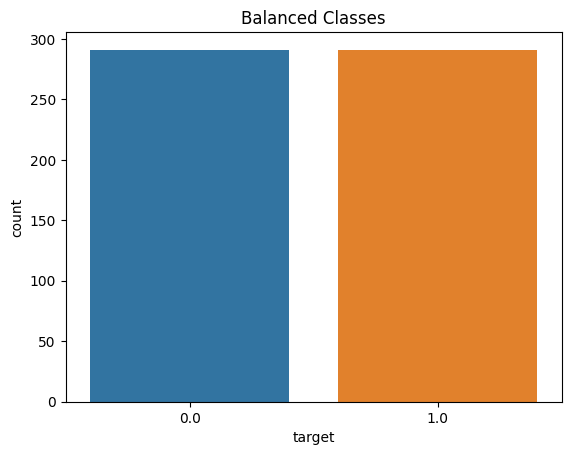

In [21]:
# Handling Data Imbalance using SMOTE
sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Visualize the balanced data
sns.countplot(x=y_train_res, label="Count")
plt.title('Balanced Classes')
plt.show()

## STEP 5: CREATE A RANDOM FOREST MODEL & TRAIN THE MDOEL:

In [22]:
# Define the RandomForestClassifier model
rfc = RandomForestClassifier(n_estimators=400)

In [23]:
# Define the parameter space for hyperparameter tuning
param_space = {
    'n_estimators': (100, 300),  # Number of trees in the forest
    'max_depth': (1, 20),         # Maximum depth of the tree
    'min_samples_split': (2, 8), # Minimum number of samples required to split an internal node
    'min_samples_leaf': (1, 4),  # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt'], # Number of features to consider at every split. 'auto' uses all features, 'sqrt' uses the square root of the number of features
    'bootstrap': [True, False],     #whether or not to use boostrapping, if false the whole dataset is used to build each tree
    'criterion': ['gini', 'entropy'] # The function to measure the quality of a split. 'gini' for Gini impurity, 'entropy' for information gain.
}

In [24]:
# Perform Bayesian Optimization with cross-validation
opt = BayesSearchCV(rfc, param_space, n_iter=32, cv=5, n_jobs=-1)

In [25]:
# Fit the model to the training data
opt.fit(X_train_res, y_train_res)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


BayesSearchCV(cv=5, estimator=RandomForestClassifier(n_estimators=400),
              n_iter=32, n_jobs=-1,
              search_spaces={'bootstrap': [True, False],
                             'criterion': ['gini', 'entropy'],
                             'max_depth': (1, 20),
                             'max_features': ['auto', 'sqrt'],
                             'min_samples_leaf': (1, 4),
                             'min_samples_split': (2, 8),
                             'n_estimators': (100, 300)})

In [26]:
# Get the best hyperparameters
best_hyperparameters = opt.best_params_
print("Best Hyperparameters:", best_hyperparameters)

Best Hyperparameters: OrderedDict([('bootstrap', False), ('criterion', 'entropy'), ('max_depth', 16), ('max_features', 'auto'), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 138)])


## STEP 6: PREDICTIONS

In [27]:
# Use the best model to make predictions
best_model = opt.best_estimator_
predictions = best_model.predict(X_test)
probabilities = best_model.predict_proba(X_test)[:, 1]

## STEP 7: EVALUATION OF THE MODEL

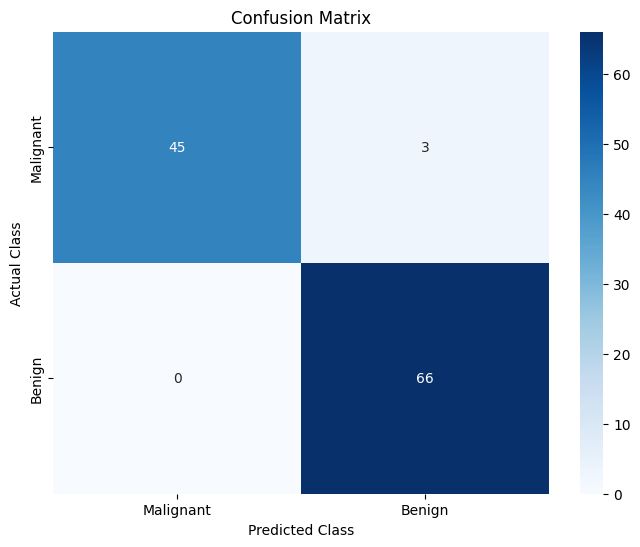

In [32]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Create a heatmap for the confusion matrix for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Malignant', 'Benign'], yticklabels=['Malignant', 'Benign'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()


The confusion matrix provides a detailed breakdown of the model's predictions against the actual labels:
- Out of the 48 actual malignant cases (label 0), the model correctly identified 45 as malignant, with no misclassifications as benign. This is reflected in the top left value (True Negative).
- The model misclassified 3 benign cases (label 1) as malignant, which is reflected in the top right value (False Positive).
- There were no instances where malignant cases were incorrectly classified as benign; hence, the bottom left value (False Negative) is 0.
- All 66 actual benign cases were correctly identified as benign by the model, shown in the bottom right value (True Positive).

Overall, this matrix indicates a highly effective model with excellent identification of benign cases. It also has a high level of accuracy in identifying malignant cases, with a very small number of benign cases being incorrectly classified as malignant.

In [29]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, predictions))


Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97        48
         1.0       0.96      1.00      0.98        66

    accuracy                           0.97       114
   macro avg       0.98      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



The classification report shows several important metrics:
- For malignant tumors (label 0), the model has a precision rate of 100%, meaning it correctly identified all malignant cases without any false positives. The recall rate is 94%, indicating that the model successfully identified 94% of all actual malignant cases.
- For benign tumors (label 1), the precision is slightly lower at 96%, meaning that 4% of tumors identified as benign by the model were actually malignant. However, the model has a perfect recall rate for benign tumors, identifying 100% of the actual benign cases.
- The overall accuracy of the model is 97%, reflecting its high level of correctness across both classes.
- The macro average, which treats both classes equally regardless of their prevalence, is 98% for precision and 97% for recall, which results in a macro-average F1-score of 97%.
- The weighted average, which accounts for the number of instances in each class, is 97% across precision, recall, and the F1-score.

Overall, this report indicates that the model is highly effective at distinguishing between benign and malignant breast tumors, with a slight bias towards ensuring all benign tumors are identified, even at the expense of incorrectly classifying a small number of malignant tumors as benign.


ROC-AUC Score: 0.9829545454545454


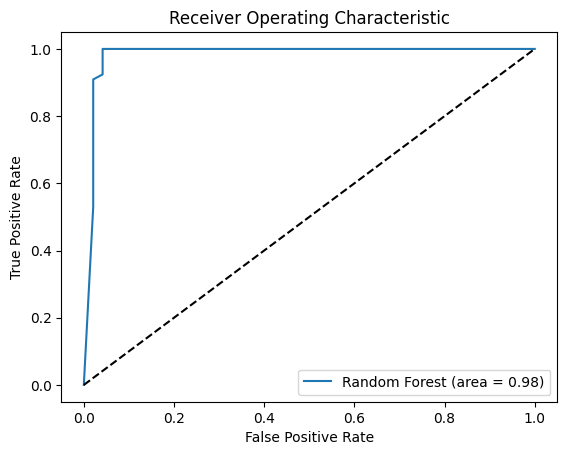

In [30]:
# ROC-AUC Score
roc_auc = roc_auc_score(y_test, probabilities)
print(f"\nROC-AUC Score: {roc_auc}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, probabilities)
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

From the Area Under the ROC Curve (AUC - ROC) Chart we can say the following:
- The curve is close to the top-left corner, which indicates a high true positive rate and a low false positive rate. In general, the closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test.
- The area under the ROC curve (AUC) is a measure of how well the probabilities from the positive classes are ranked with respect to the negative classes. An AUC of 1.0 represents a perfect model, while an AUC of 0.5 represents a useless model. Here the model has an AUC of 0.98, which means the model does an excellent job of ranking the positive class higher than the negative class.



### **Conclusion:**
To summarize, the model that was trained is performing very well on the test set. It has high precision, recall, and F1-scores across both classes. The confusion matrix indicates that it is particularly good at correctly identifying the positive class (with high sensitivity), and the ROC-AUC score suggests that it does an excellent job of distinguishing between the classes.


Considering the context of medical diagnosis, where the positive class (label 1) indicates benign breast cancer and the negative class (label 0) signifies malignant cases, the model demonstrates a high degree of accuracy in detecting benign cases (evidenced by a high recall for the positive class). Concurrently, it minimizes the rate of mistakenly identifying malignant tumors as benign (as indicated by the high precision for the positive class). Achieving this equilibrium is vital in the medical field, as incorrectly identifying malignant tumors as benign (false negatives) or benign tumors as malignant (false positives) can lead to serious health implications and treatment errors.

## STEP 8: SAVE THE MODEL

In [31]:
# Save the best model to a pickle file
import pickle
filename = 'BreastCancer_rfModel.sav'
pickle.dump(best_model,open(filename,'wb'))